In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch

In [48]:
input_molecule_smi = "OCC1OC(O)C(C(C1O)O)O" # D-glucose

yaml_file= '/Users/mwoulfe/Documents/Research/Cantera_Glucose/yamls/glucose/crit_paths.yaml'
gas = ct.Solution(yaml_file)
r = ct.IdealGasConstPressureReactor(contents=gas, energy='off', name='isothermal_reactor')
sim = ct.ReactorNet([r])

states = ct.SolutionArray(gas, extra=['t'])
print(gas(), f"T0: {gas.T}", f"Species: {len(gas.Y)}", f"Reactions: {len(states.reactions())}")


  crit_paths:

       temperature   623 K
          pressure   1.0132e+05 Pa
           density   3.5241 kg/m^3
  mean mol. weight   180.16 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy                 0                 0  J
   internal energy            -28752       -5.1799e+06  J
           entropy                 0                 0  J/K
    Gibbs function                 0                 0  J
 heat capacity c_p                 0                 0  J/K
 heat capacity c_v           -46.151           -8314.5  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
OCC1OC(O)C(C(C1O)O)O                 1                 1                 0
     [  +82 minor]                 0                 0  

None T0: 623.0 Species: 83 Reactions: 198


In [49]:
species = states.species_names
rxn_list = states.reactions()
rxns = gas.reactions()

# Sim timeframe
sim.verbose = True
dt_max = .1  #secs
t_end = 12000 * dt_max
print('{:10s} {:10s} {:10s} {:14s}'.format(\
    't [s]', 'T [K]', 'P [Pa]', f'Y ({input_molecule_smi})'))


states.append(r.thermo.state, t=sim.time) # remove to stabalize CNF
while sim.time < t_end:
    sim.advance(sim.time + dt_max)

    states.append(r.thermo.state, t=sim.time)

print(sim.time)


t [s]      T [K]      P [Pa]     Y (OCC1OC(O)C(C(C1O)O)O)
Initializing reactor network.
Reactor 0: 85 variables.
              0 sensitivity params.
Number of equations: 85
Maximum time step:                0
1200.000000000004


In [50]:
# determine what rule for plotting ordering
rule = 'css'
tracker = []
if rule == 'cnf':
    # parse depth from yaml name. If initial depth... 
    if yaml_name.split("_")[-1].split('.')[0] == 0:
        # use every flux datapoint
        spe_net = np.trapz(states.net_production_rates[:], dx=time_step, axis=0)
    # ignore first timestep
    else: spe_net = np.trapz(states.net_production_rates[1:], dx=time_step, axis=0)
    net_states = zip(spe_net,species,range(len(species)))
    net_states = sorted(net_states,reverse=True)[:]
    tracker.append(spe_net)

elif rule == 'css':
    net_states = zip(states.X[-1,:],species,range(len(species)))
    net_states = sorted(net_states,reverse=True)[:]
    tracker.append(states.X[-1,:])

elif rule == 'final_mass':
    net_states = zip(states.Y[-1,:],species,range(len(species)))
    net_states = sorted(net_states,reverse=True)[:]
    tracker.append(states.Y[-1,:])

elif rule == 'cum_conc':
    conc_net = np.trapz(states.x[:], dx=time_step, axis=0)
    net_states = zip(conc_net,species,range(len(species)))
    net_states = sorted(net_states,reverse=True)[:]
    tracker.append(conc_net)
    

In [51]:

# font preference
font= 'Helvetica'
title_font = 22
subtitle_font = 16
tick_font = 14

# Setting global parameters
plt.rcParams['font.size'] = 12  # Sets the default font size
plt.rcParams['font.family']     = 'sans-serif'
plt.rcParams['font.sans-serif'] = font  # Sets the default font family
plt.rc('xtick', labelsize=title_font)  # For x tick labels
plt.rc('ytick', labelsize=title_font)

36 (6.97491715645578e-15, 'OCC1OC(O)C(C(C1O)O)O', 0)


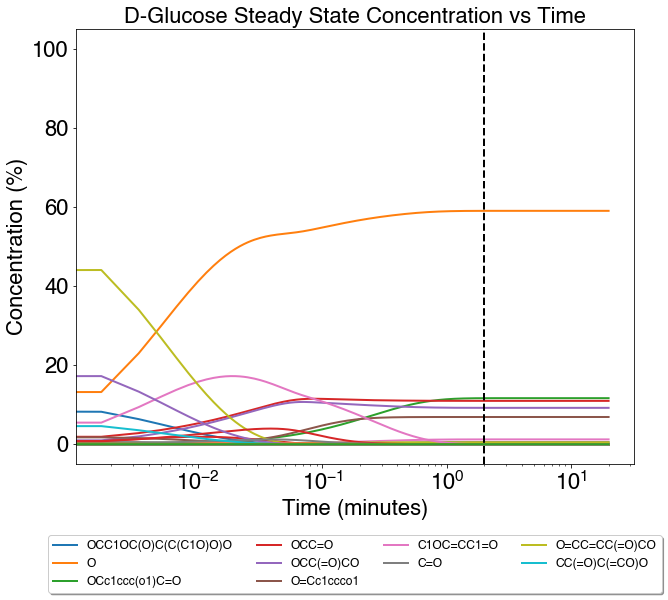

In [52]:
num = 1000 # num of states to include in plot
legend_num = 10

# get indices of species
plt_spe = []
for i, val in enumerate(net_states):
    if i <= num:
        plt_spe.append(val[1])
plt_spe.insert(0,input_molecule_smi)


# get list of indices ordered by concentration
ord_con = []
for c, v in enumerate(net_states):
#     print(c, v[1])
    if input_molecule_smi == v[1]:
        print(c, v)
        ord_con.insert(0, net_states[c][2]) # always put starting molecule into ordered list
    else:
        ord_con.append(net_states[c][2])



plt.figure(figsize=(10,8))
plt.plot(states.t[:] / 60, states.X[:,(ord_con[:num+2])] * 100, linewidth=2)
plt.legend(plt_spe[:legend_num], loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

# Add a vertical line at x = 2
plt.axvline(x = 2, color='black', linestyle='--', linewidth=2, label='t = 2 minutes')


# plt.ylim(0,50)

# remove tick labels, but keep marks
# plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
# plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

plt.xlabel('Time (minutes)',fontsize = title_font, fontname=font, fontweight='bold')
plt.xscale('log')
plt.ylabel(f'Concentration (%)',fontsize = title_font, fontname=font, fontweight='bold')
plt.title(f"D-Glucose Steady State Concentration vs Time",fontsize = title_font, fontname=font, fontweight='bold')



plt.show()

len(species): 83


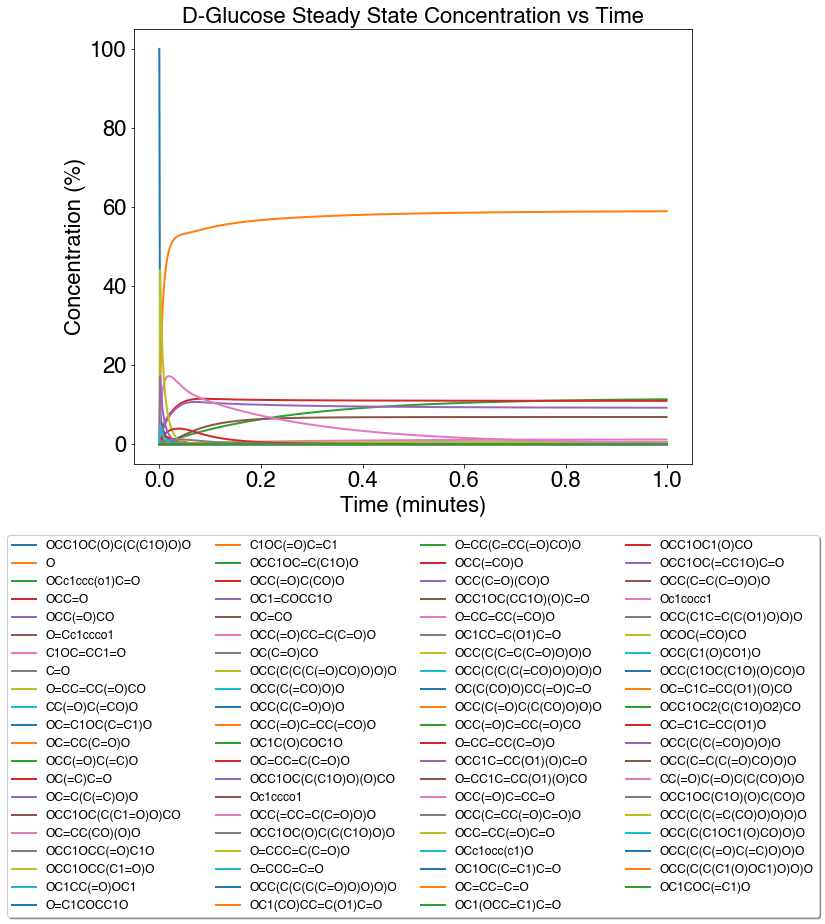

In [53]:

# zoomed in on first minute
print(f"len(species): {len(species)}")
plt.figure(figsize=(10,8))
plt.plot(states.t[:600] / 60, states.X[:600,(ord_con[:num+2])] * 100, linewidth=2)
plt.legend(plt_spe, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=4)
plt.xlabel('Time (minutes)',fontsize = title_font, fontname=font, fontweight='bold')
plt.ylabel(f'Concentration (%)',fontsize = title_font, fontname=font, fontweight='bold')
plt.title(f"D-Glucose Steady State Concentration vs Time",fontsize = title_font, fontname=font, fontweight='bold')
plt.show()

Text(0.5, 1.0, 'D-Glucose Net production vs Time')

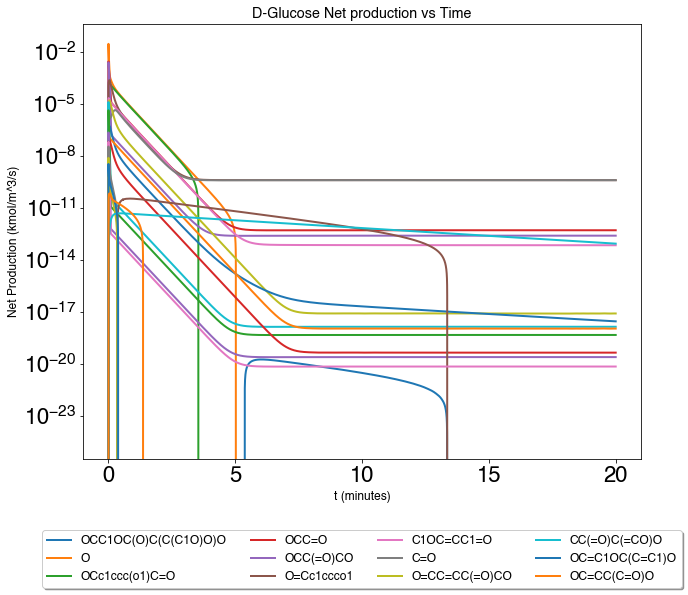

In [54]:
# net production: redefine num of species in plot for clarity
num = 20
plt.figure(figsize=(10,8))
plt.plot(states.t[:] / 60, states.net_production_rates[:,(ord_con[:num+2])], linewidth=2) 
plt.legend(plt_species, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=4)
plt.xlabel('t (minutes)')
plt.yscale('log')
# plt.xscale('log')
plt.ylabel(f'Net Production (kmol/m^3/s)')
plt.title(f"D-Glucose Net production vs Time")

In [64]:
# Printed analysis
threshhold = .01 # mass percent seed for next lvl of exploration
var = 10

final_states = zip(states.Y[-1,:],species,range(len(species)))
final_states = sorted(final_states,reverse=True)[:]

print(f"\nMass Percents over 1%:")
for i, val in enumerate(final_states):
    if val[0] > threshhold:
        if val[1]== input_molecule_smi:
            print(f" {val[1]:<15} Mass Percent: {val[0]:.4f}")
        else:
            print(f" {val[1]:<22}     Mass Percent: {val[0]:.4f}")
            
print(f"\nFinal Concentrations over 1%:")
sum_con = 0
final_moles = zip(states.X[-1,:],species,range(len(species)))
final_moles = sorted(final_moles,reverse=True)[:]
for val in (final_moles[:var]):
    sum_con+=val[0]
    if val[1]== input_molecule_smi:
        print(f" {val[1]:<15} Concentration: {val[0]:.4f}")
    else:
        print(f" {val[1]:<22}     Concentration: {val[0]:.4f}")
print(f'\nSum of printed concentrations: {sum_con:.5f}')

# cnf 
if fnmatch.fnmatch(yaml_file, "*_0.yaml") or fnmatch.fnmatch(yaml_file, "*_pre*"):
    spe_net = np.trapz(states.net_production_rates[:], dx=dt_max, axis=0)
else: spe_net = np.trapz(states.net_production_rates[1:], dx=dt_max, axis=0)
    
top_n = sorted(range(len(spe_net)), key=lambda i: spe_net[i], reverse=True)[:var]

print("\nCNF Top Species")
for i in top_n:
    print(f"{species[i]:<24}CNF: {spe_net[i]:<.6f}")



Mass Percents over 1%:
 OCc1ccc(o1)C=O             Mass Percent: 0.3023
 O                          Mass Percent: 0.2189
 OCC(=O)CO                  Mass Percent: 0.1705
 O=Cc1ccco1                 Mass Percent: 0.1361
 OCC=O                      Mass Percent: 0.1355
 C1OC=CC1=O                 Mass Percent: 0.0211
 O=CC=CC(=O)CO              Mass Percent: 0.0111

Final Concentrations over 1%:
 O                          Concentration: 0.5903
 OCc1ccc(o1)C=O             Concentration: 0.1164
 OCC=O                      Concentration: 0.1096
 OCC(=O)CO                  Concentration: 0.0919
 O=Cc1ccco1                 Concentration: 0.0688
 C1OC=CC1=O                 Concentration: 0.0122
 C=O                        Concentration: 0.0055
 O=CC=CC(=O)CO              Concentration: 0.0047
 CC(=O)C(=CO)O              Concentration: 0.0002
 OC=C1OC(C=C1)O             Concentration: 0.0002

Sum of printed concentrations: 0.99982

CNF Top Species
O                       CNF: 0.018067
OCC=O  